# Political News and the Fair Exposure Problem under Homophily

## All required libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import beta
from matplotlib import pyplot as plt
import re

import random
import platform_opt
from players import *

from IPython.display import Markdown, display, Latex
from scipy.stats import norm

def printmd(string):
    display(Markdown(string))

## Important Parameters

- $T$: Number of timesteps
- $M$: Finite mass of user
- $g \in \{A, B\}$: Political Affliation/ Preference
- $\pi_g \in (0, 1)$: Fraction of users from group $g$ 
- $t \in \{1, \cdots , T\}$:  Discrete Time T $\leq $ M
- $s \in \{a, b\}$: Article sources afliated with $A, B$
- $\theta_{A}, \theta_B \in [0, 1]$: Fraction of users shown an article
- $P_{g,s}$: Probability of users of group $g$ who like an article from source $s$
- $c > 0$: Cost user incur for clicking an article
- $v > 0$: Utility users get for liking an article
- $q_{g} > 0.5$: Probability of in-group propagation 

## Load and clean the dataset:  [Replication Data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/AAI7VA)

### Dataset description borrowed from ReadMe.md of [Replication Data](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/AAI7VA)

#### Top500 

- domain ---> s: domain
- l1 ---> $P_{A}$ : proportion of shares with liberal alignment from s
- r1 ---> $P_{B}$: proportion of shares with conservative alignment from s

The top 500 most shared domains have each been shared at least 44,000 times. 
- T = ?
- |a| < |b|

This set of domains covers over 80% of the URLs classified as hard content that

#### Homophily

- viewer ---> A / B: affiliation of an individual in the sampling frame of the study.
- friend ---> A / B : affiliation of friend.
- frac_of_friends --->: bucketed (in increments of 0.01) fraction of friends with the given affiliation.
- density --->: proportion of friends within the given bucket.



In [2]:
hard_news = ['nytimes.com', 'huffingtonpost.com', 'news.yahoo.com','cnn.com','foxnews.com','video.foxnews.com',
  'foxnewsinsider.com', 'npr.org','theblaze.com','abcnews.go.com', 'msnbc.MSN.com', 'dailycaller.com',
  'examiner.com', 'guardian.co.uk', 'cbsnews.com','politico.com','forbes.com', 'dailykos.com', 'reuters.com',
  'salon.com','motherjones.com', 'latimes.com','slate.com', 'online.wsj.com', 'realclearpolitics.com', 'theatlantic.com',
  'bbc.co.uk', 'businessinsider.com', 'video.msnbc.msn.com', 'thehill.com', 'townhall.com', 'content.usatoday.com',
  'money.cnn.com', 'breitbart.com', 'aljazeera.com', 'thedailybeast.com', 'telegraph.co.uk', 'bloomberg.com',
  'maddowblog.msnbc.com','thenation.com','glennbeck.com', 'talkingpointsmemo.com', 'nationalreview.com','usnews.nbcnews.com',
  'politicalticker.blogs.cnn.com','aclu.org','sfgate.com','chicagotribune.com', 'thegatewaypundit.com','nydailynews.com', 'politifact.com',
  'csmonitor.com', 'rushlimbaugh.com', 'pbs.org', 'usatoday.com','newamerican.com', 'thenewcivilrightsmovement.com', 'front.moveon.org','thinkprogress.org', 'addictinginfo.org',
  'alternet.org', 'rawstory.com',  'infowars.com','newsmax.com', 'rt.com','politicususa.com','truth-out.org', 'commondreams.org',
  'tpnn.com',  'democracynow.org', 'americanthinker.com', 'advocate.com','lifenews.com', 'aclj.org', 'readersupportednews.org',
  'humanevents.com', 'prisonplanet.com', 'godfatherpolitics.com', 'newsbusters.org',
  'nypost.com', 'lifesitenews.com', 'mediamatters.org']

In [9]:
# load the datasets
data_path = "datasets/replication_exposure/"
homophily_data = pd.read_csv(data_path+"homophily_density", sep=",", quotechar='"', encoding="utf8")
top_500_data = pd.read_csv(data_path+"top500", sep=",", quotechar='"', encoding="utf8", )

In [10]:
# rename homophily columns
col_names=['Group1', 'Group2', 'Frac_of_Friends', 'Density']
homophily_data.columns = col_names

In [30]:
# Drop moderates from the homophily data
h = homophily_data.loc[~((homophily_data['Group1']=='Moderates') | (homophily_data['Group2']=='Moderate friends'))]
# replace Liberals with A
# replace conservatives with B
homophily = h.copy()
homophily['Group1'] = homophily['Group1'].replace(['Liberals'],'A')
homophily['Group1'] = homophily['Group1'].replace(['Conservatives'],'B')
homophily['Group2'] = homophily['Group2'].replace(['Liberal friends'],'A')
homophily['Group2'] = homophily['Group2'].replace(['Conservative friends'],'B')

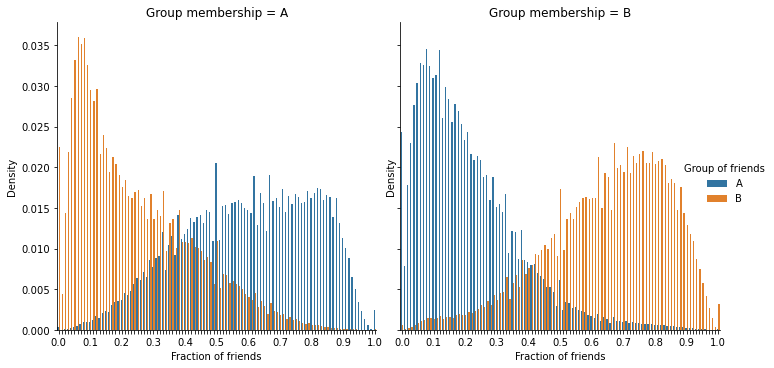

In [41]:
g = sns.catplot(data=homophily, kind='bar',
            x='Frac_of_Friends', y='Density',
            hue='Group2', col='Group1')

for ax in g.axes.flat:
    ax.set_title(ax.title.get_text().replace('Group1', 'Group membership'))
    # reduce xtick density
    for ind, label in enumerate(ax.get_xticklabels()):
        label.set_visible(ind % 10 == 0)
        
g._legend.set_title('Group of friends')

g.set(xlabel='Fraction of friends', ylabel='Density')

In [20]:
homophily.shape

(565, 4)

In [8]:
group_A = homophily[homophily.Group1=='A'][:-36]
group_B = homophily[homophily.Group1=='B'][:-29]
groups = pd.concat([group_A, group_B], ignore_index=True)

In [9]:
# remove very liberal, moderates, and very conservatives from top500 data
domains = top_500_data.drop(['l2', 'avg_align', 'n', 'r2'], axis=1)
# replace liberal with A and conservative with B
domains.columns = ['s', 'P_A', 'P_B']

In [10]:
for dom in hard_news:
    domains.replace(re.compile('.*'+dom+'.*'), 'a', inplace=True)

domains['s'].mask(domains['s'] != 'a', 'b', inplace=True)


In [11]:
domains.shape

(500, 3)

In [12]:
data = pd.concat([domains, groups], axis=1)
dataset = data.sample(frac=1).reset_index(drop=True)
dataset['q_g'] = dataset.Frac_of_Friends * dataset.Density * 100
facebook_data = dataset[['s', 'P_A', 'P_B', 'Group1', 'Group2', 'q_g', 'Density']]
facebook_data.head()

,s,P_A,P_B,Group1,Group2,q_g,Density
0,b,0.1095,0.1852,B,B,0.000433,0.000008
1,b,0.0004,0.1707,B,B,0.046380,0.002209
2,a,0.0055,0.0005,A,A,0.028709,0.002051
3,b,0.0003,0.9591,B,B,0.025910,0.000291
4,a,0.1049,0.0014,A,A,0.249245,0.008595


In [13]:
facebook_data.Group1.value_counts(normalize=True).rename("$\pi$").reset_index()

,index,$\pi$
0,B,0.5
1,A,0.5


In [116]:
groupA = facebook_data [(facebook_data.Group1 == 'A') & (facebook_data.Group2 == 'A') ]  
display(Latex("$\nq_A: {}$".format(groupA.q_g.sum()/100)))
display(Latex("$1 - q_A: {}$".format(1-groupA.q_g.sum()/100)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [117]:
groupB = facebook_data [(facebook_data.Group1 == 'B') & (facebook_data.Group2 == 'B') ]  
display(Latex("\n$q_B: {}$".format(groupB.q_g.sum()/100)))
display(Latex("$1 - q_B: {}$".format(1-groupB.q_g.sum()/100)))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

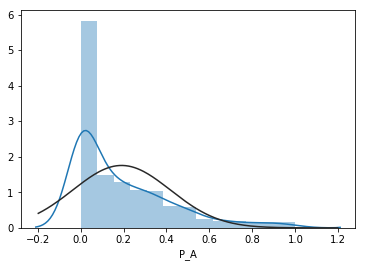

In [119]:
sns.distplot(facebook_data.P_A, fit=norm, kde=True)

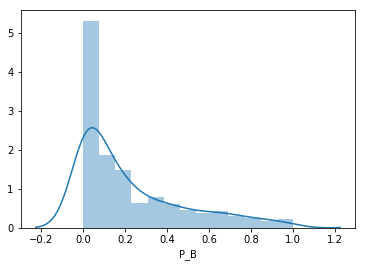

In [121]:
sns.distplot(facebook_data.P_B)

In [128]:
facebook_data.dropna().head()

,s,P_A,P_B,Group1,Group2,q_g,Density
0,b,0.1847,0.1492,B,B,0.511813,0.021326
1,b,0.1066,0.4735,B,B,0.326444,0.007962
2,b,0.6115,0.0133,A,A,0.752159,0.037608
3,a,0.2693,0.1440,A,A,0.174853,0.002775
4,b,0.0473,0.0000,A,A,0.000850,0.000213


In [130]:
(facebook_data.P_B == 0).any()

True

In [131]:
(facebook_data.P_A == 0).any()

True

In [139]:
(facebook_data.P_A == 1).any()

True

In [138]:
(facebook_data.P_A == 1).any()

True

In [140]:
facebook_data.loc[facebook_data['P_A'] == 0, 'P_A'] = 0.0000000001
facebook_data.loc[facebook_data['P_B'] == 0, 'P_B'] = 0.0000000001
facebook_data.loc[facebook_data['P_A'] == 1, 'P_A'] = 0.99998
facebook_data.loc[facebook_data['P_B'] == 1, 'P_B'] = 0.99998
facebook_data.head()

,s,P_A,P_B,Group1,Group2,q_g,Density
0,b,0.1847,1.492000e-01,B,B,0.511813,0.021326
1,b,0.1066,4.735000e-01,B,B,0.326444,0.007962
2,b,0.6115,1.330000e-02,A,A,0.752159,0.037608
3,a,0.2693,1.440000e-01,A,A,0.174853,0.002775
4,b,0.0473,1.000000e-10,A,A,0.000850,0.000213


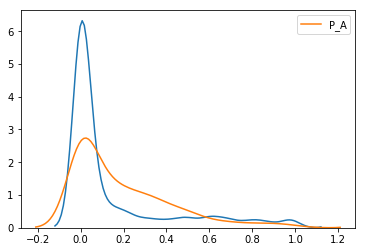

In [146]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a1, b1, loc1, scale1 = beta.fit(facebook_data.P_A, floc=0, fscale=1)
a1, b1
sns.kdeplot(np.random.beta(a=a1, b=b1, size=facebook_data.P_A.shape[0]))
sns.kdeplot(facebook_data.P_A)

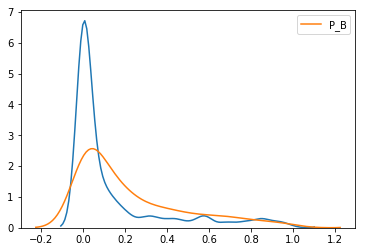

In [148]:
# MLE estimates for the parameters of the beta distribution (for p_A)
a2, b2, loc2, scale2 = beta.fit(facebook_data.P_B, floc=0, fscale=1)
a2, b2
sns.kdeplot(np.random.beta(a=a1, b=b1, size=facebook_data.P_B.shape[0]))
sns.kdeplot(facebook_data.P_B)